# Polyhedra in input space (experiment)

Some useful links
* [Paper with the idea](https://arxiv.org/pdf/2306.17418)
* [Paper that make the toolbox](https://www.frontiersin.org/journals/big-data/articles/10.3389/fdata.2023.1274831/full#B10)
* [GitHub repository with code](https://github.com/cglrtrgy/GoL_Toolbox/tree/main)


This notebook is inspired by their [demo notebook](https://github.com/cglrtrgy/GoL_Toolbox/blob/main/Demo_V0.ipynb).


## Summary of core idea

## Dummy data and model

We use the `make_moons` dataset from `scikit-learn`:

In [457]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from src import functions
from src import trainer
from src import models

# Generate data
x, y = make_moons(1000, noise=0.1)
x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

# Useful function to convert tensors to numpy arrays
def to_np(x):
    return x.cpu().detach().numpy()

Train a simple binary classifier with ReLU activation on the two-moons dataset. 

100%|██████████| 5000/5000 [00:06<00:00, 797.77it/s]


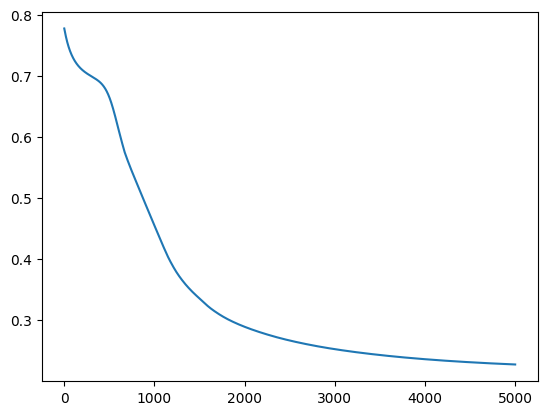

In [458]:
# Dummy model to test the functions
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.l1 = nn.Linear(2, 3)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(3, 3)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(3, 3)
        self.relu3 = nn.ReLU()
        self.out = nn.Linear(3, 1)

    def forward(self, x):

        out = x
        out = self.relu1(self.l1(out))
        out = self.relu2(self.l2(out))
        out = self.relu3(self.l3(out))
        out = torch.sigmoid(self.out(out).squeeze())

        return out


# Train the model 

EPOCHS = 5000
criterion = nn.BCELoss()

model = MLP()
optimizer = torch.optim.Adam(model.parameters())
losses = []

for epoch in trange(EPOCHS):
    model.train()
    optimizer.zero_grad()

    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    optimizer.zero_grad()

plt.figure(1)
plt.plot(losses)
plt.show()


## 1 - Bit-vector

This is found using a random data point on a pre-trained model, and creating vector of the activations, 0 if 0 or 1 if activated. This is the same as taking the derivative of the activation and stacking them. 

In [459]:
model.eval()
# For random sample, just use first sample for now
random_sample = to_np(x[0].unsqueeze(0).T)
random_sample

array([[-0.16529551],
       [ 0.67604095]], dtype=float32)

In [460]:
# Get the bit vector. This will be a list of bit vectors, one for each sample, whose length is the number of ReLU activations in the model, stacked across layers.
bit_vector_of_sample  = functions.bit_vector_from_relus(model, random_sample, stack_layers = True, verbose=False, get_unique_bit_vectors_only=False)
print("Shape of the bit vector: ")
bit_vector_of_sample[0].shape
# print(bit_vector_of_an_image)

Shape of the bit vector: 


(9, 1)

In [461]:
# Get the same bit vectors, but without stacking across layers.
bit_vector_of_sample_no_stack  = functions.bit_vector_from_relus(model, random_sample, stack_layers = False, verbose=False, get_unique_bit_vectors_only=False)

In [462]:
counter = 1
for a_bit_vector in bit_vector_of_sample_no_stack[0]:
    print(f"Shape of the {counter}. hidden layer's bit vector: {a_bit_vector.shape}")
    counter += 1
    

Shape of the 1. hidden layer's bit vector: (3, 1)
Shape of the 2. hidden layer's bit vector: (3, 1)
Shape of the 3. hidden layer's bit vector: (3, 1)


In [463]:
print("Bit vector of the first sample:")
print(bit_vector_of_sample)
print("Bit vector of the first sample, without stacking across layers:")
print(bit_vector_of_sample_no_stack)

Bit vector of the first sample:
[array([[0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])]
Bit vector of the first sample, without stacking across layers:
[[array([[0],
       [0],
       [1]]), array([[0],
       [1],
       [0]]), array([[0],
       [1],
       [0]])]]


## 2 - Linear model for polyhedron

The aim is to derive the linear model of a given data point. That is, given a data point $\mathbf{x}$, find $A$ and $\mathbf{c}$ such that $A\mathbf{x}\leq \mathbf{c}$

In [464]:
# Find Ars and crs for random sample (rs)
Ars, crs = functions.get_inequalities(model, random_sample, return_bit_vec_list=False)

In [465]:
#Linear model: Ax <= c.
print("Shape of A: ", Ars[0].shape)
print("Shape of c: ", crs[0].shape)

Shape of A:  (9, 2)
Shape of c:  (9, 1)


In [466]:
print("A: ", Ars)
print("c: ", crs)

A:  [array([[-1.86200130e+00, -1.18256889e-01],
       [-4.25769567e-01, -5.79862222e-02],
       [-4.20576259e-02,  1.45148993e+00],
       [-1.55777967e-02,  5.37619859e-01],
       [-7.31283381e-02,  2.52380023e+00],
       [-1.89698809e-02,  6.54687240e-01],
       [ 6.07137301e-04, -2.09534812e-02],
       [-1.28932278e-01,  4.44970202e+00],
       [ 6.51421449e-03, -2.24818127e-01]])]
c:  [array([[0.32663339],
       [0.55977219],
       [1.26283789],
       [0.7799313 ],
       [2.2123047 ],
       [0.60595183],
       [0.04760454],
       [3.86738811],
       [0.24979932]])]


## 3 - Minimum set of the linear model (active bits of the bit vector)

In [467]:
indices_for_active_bits = functions.active_bits_index(Ars, crs, verbose=False, n_jobs=2)
print("Active bit index list for random sample's bit vector: ")
indices_for_active_bits

Active bit index list for random sample's bit vector: 


array([0, 7, 8])

In [468]:
Ars, crs, bit_vectors = functions.get_inequalities(model, random_sample, return_bit_vec_list=True, input_dimension=2)

indices_for_active_bits, stats = functions.active_bits_index_2(Ars[0], crs[0].reshape(-1))


print("Shape of Ars: ", Ars[0].shape)
print("Shape of crs: ", crs[0].shape)
print("Shape of bit_vectors: ", bit_vectors[0].shape)
print("Active bit index list: ", indices_for_active_bits)


# For this to work, each layer must have the same number of nodes. 
polyhedra_list, active_bit_count_list = functions.get_polytope_list(bit_vectors[0], indices_for_active_bits, model=model)
print("# of polyhedra:" ,len(polyhedra_list))

Shape of Ars:  (9, 2)
Shape of crs:  (9, 1)
Shape of bit_vectors:  (9, 1)
Active bit index list:  [0 7 8]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 5)

In [ ]:
# What is this
t = [np.array_split(a_poly, 2) for a_poly in polyhedra_list]
t

[[array([[1],
         [1],
         [1]]),
  array([[0],
         [1],
         [0]])],
 [array([[1],
         [0],
         [1]]),
  array([[0],
         [1],
         [0]])],
 [array([[1],
         [1],
         [0]]),
  array([[0],
         [1],
         [0]])],
 [array([[1],
         [1],
         [1]]),
  array([[0],
         [0],
         [0]])],
 [array([[1],
         [1],
         [1]]),
  array([[0],
         [1],
         [1]])],
 [array([[1],
         [0],
         [1]]),
  array([[0],
         [0],
         [0]])],
 [array([[1],
         [1],
         [0]]),
  array([[0],
         [1],
         [1]])],
 [array([[0],
         [1],
         [1]]),
  array([[0],
         [0],
         [0]])],
 [array([[1],
         [1],
         [1]]),
  array([[1],
         [0],
         [0]])],
 [array([[1],
         [1],
         [1]]),
  array([[0],
         [0],
         [1]])],
 [array([[1],
         [1],
         [1]]),
  array([[1],
         [1],
         [1]])],
 [array([[0],
       

In [ ]:
print("List of polyhedra:\n ",polyhedra_list )

List of polyhedra:
  [array([[1],
       [1],
       [1],
       [0],
       [1],
       [0]]), array([[1],
       [0],
       [1],
       [0],
       [1],
       [0]]), array([[1],
       [1],
       [0],
       [0],
       [1],
       [0]]), array([[1],
       [1],
       [1],
       [0],
       [0],
       [0]]), array([[1],
       [1],
       [1],
       [0],
       [1],
       [1]]), array([[1],
       [0],
       [1],
       [0],
       [0],
       [0]]), array([[1],
       [1],
       [0],
       [0],
       [1],
       [1]]), array([[0],
       [1],
       [1],
       [0],
       [0],
       [0]]), array([[1],
       [1],
       [1],
       [1],
       [0],
       [0]]), array([[1],
       [1],
       [1],
       [0],
       [0],
       [1]]), array([[1],
       [1],
       [1],
       [1],
       [1],
       [1]]), array([[0],
       [0],
       [1],
       [0],
       [0],
       [0]]), array([[1],
       [1],
       [0],
       [1],
       [1],
       [1]]), array([[0],
    

In [ ]:
counter = 1
for a_polyhedra in polyhedra_list:
    print(f"Shape of {counter}. polyhedra: ",a_polyhedra.shape )
    counter += 1

Shape of 1. polyhedra:  (6, 1)
Shape of 2. polyhedra:  (6, 1)
Shape of 3. polyhedra:  (6, 1)
Shape of 4. polyhedra:  (6, 1)
Shape of 5. polyhedra:  (6, 1)
Shape of 6. polyhedra:  (6, 1)
Shape of 7. polyhedra:  (6, 1)
Shape of 8. polyhedra:  (6, 1)
Shape of 9. polyhedra:  (6, 1)
Shape of 10. polyhedra:  (6, 1)
Shape of 11. polyhedra:  (6, 1)
Shape of 12. polyhedra:  (6, 1)
Shape of 13. polyhedra:  (6, 1)
Shape of 14. polyhedra:  (6, 1)
Shape of 15. polyhedra:  (6, 1)
Shape of 16. polyhedra:  (6, 1)
Shape of 17. polyhedra:  (6, 1)
Shape of 18. polyhedra:  (6, 1)
Shape of 19. polyhedra:  (6, 1)
Shape of 20. polyhedra:  (6, 1)
Shape of 21. polyhedra:  (6, 1)
Shape of 22. polyhedra:  (6, 1)
Shape of 23. polyhedra:  (6, 1)


In [ ]:
counter = 1
for a_neigh_count in active_bit_count_list:
    print(f"{counter}. polyhedra has : ", a_neigh_count, "neighbors" )
    counter += 1

1. polyhedra has :  4 neighbors
2. polyhedra has :  2 neighbors
3. polyhedra has :  2 neighbors
4. polyhedra has :  5 neighbors
5. polyhedra has :  4 neighbors
6. polyhedra has :  3 neighbors
7. polyhedra has :  3 neighbors
8. polyhedra has :  4 neighbors
9. polyhedra has :  3 neighbors
10. polyhedra has :  3 neighbors
11. polyhedra has :  4 neighbors
12. polyhedra has :  3 neighbors
13. polyhedra has :  3 neighbors
14. polyhedra has :  3 neighbors
15. polyhedra has :  3 neighbors
16. polyhedra has :  4 neighbors
17. polyhedra has :  3 neighbors
18. polyhedra has :  3 neighbors
19. polyhedra has :  3 neighbors
20. polyhedra has :  6 neighbors
21. polyhedra has :  3 neighbors
22. polyhedra has :  3 neighbors
23. polyhedra has :  2 neighbors


In [ ]:
# random_sample = np.array([[0.], [0.]])  # Example random sample for testing

Ars, crs, bit_vectors = functions.get_inequalities(model, random_sample, return_bit_vec_list=True, input_dimension=2)

indices_for_active_bits, stats = functions.active_bits_index_2(Ars[0], crs[0].reshape(-1))

sample_bit_vector_list = functions.bit_vector_from_relus(model, random_sample, get_unique_bit_vectors_only=True)

sample_bit_vector_list = np.vstack(sample_bit_vector_list[0])

polytope_list, active_bit_count_list = functions.get_polytope_list(sample_bit_vector_list, indices_for_active_bits, input_dimension=2, model=model)

bit_string_list_from_alg = polyhedra_list

def divide_column_vector(column_vector):
    return np.array_split(column_vector, 2)

list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]

A_alg, c_alg = functions.get_inequalities(model, list_of_lists_of_column_vectors_alg, is_input_sample=False, return_bit_vec_list=False, input_dimension=2)
print("Length of A_alg: ", len(A_alg))
print("Solver name:", stats.solver_name)

Length of A_alg:  23
Solver name: CLARABEL


In [ ]:
from intvalpy import lineqs

verticles_list_alg = []

bound = 10

print(random_sample)

for A, c in zip (A_alg, c_alg):
    verticles = lineqs(-A, -c, title='Solution', color='red', save=False, show=False, bounds = [[-bound, -bound], [bound, bound]])
    verticles_list_alg.append(verticles)
len(verticles_list_alg)

[[2.0558    ]
 [0.25407973]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

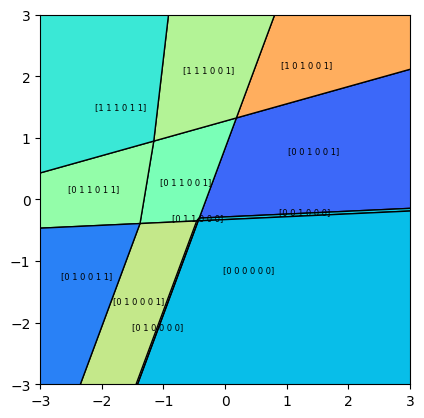

The number of polytopes within the boundaries is: 12


In [ ]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
bound = 3


fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
patches = []
num_polygons = len(verticles_list_alg)
colors = [np.random.randint(1, 300) for i in range(num_polygons)]
cmap = matplotlib.colormaps['rainbow']

polytopes_within_boundaries = 0  # Counter for polytopes within boundaries

for i in range(num_polygons):
    vertices_i = verticles_list_alg[i]
    
    # Check if any vertex falls within the boundaries
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
    clipped_vertices = functions.clip_vertices(vertices_i.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=vertices_i,
                          closed=True,
                          facecolor=cmap(colors[i]),
                          edgecolor='black',
                          label=np.transpose(bit_string_list_from_alg[i])[0],
                         )
        ax.add_patch(polygon)
        
        center_x, center_y = functions.calculate_center_of_mass(clipped_vertices)
#         min_x = min(coord[0] for coord in clipped_vertices)
#         max_x = max(coord[0] for coord in clipped_vertices)
#         min_x = max(min_x, -bound)
#         max_x = min(max_x, bound)
#         center_x = 0.5 * (max_x - min_x) + min_x
#         min_y = min(coord[1] for coord in clipped_vertices)
#         max_y = max(coord[1] for coord in clipped_vertices)
#         min_y = max(min_y, -bound)
#         max_y = min(max_y, bound)
#         center_y = 0.5 * (max_y - min_y) + min_y

        ax.annotate(text=polygon.get_label(), xy=(center_x, center_y), ha='center', fontsize=6)
        patches.append(polygon)
        
        polytopes_within_boundaries += 1
#         print(vertices_i,bit_string_list_from_alg[i],min_x,min_y,center_x,center_y )
        
        
        

ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
np.random.seed(10)
colors = [np.random.randint(1, 1000) for i in range(len(patches))]
plt.show()

print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")